In [13]:
from typing import Tuple

In [1]:
from numpy import *  # mmmmmm  crunchy

# Start by defining some parameters. Change these if you like!
cont_zp = 500.0
cont_slope = 5.0
amplitude = 150.0
width = 0.5
center = 5.0

# Next, a grid of wavelength channels (assumed to have no uncertainty)
wave = linspace(0,10,100)

# The 'true' observations
flux = amplitude * exp(-0.5 * power(wave-center, 2) / width**2) + cont_zp + cont_slope*wave

# The actual observations = true observations + Poisson noise
obs_flux = random.poisson(flux)

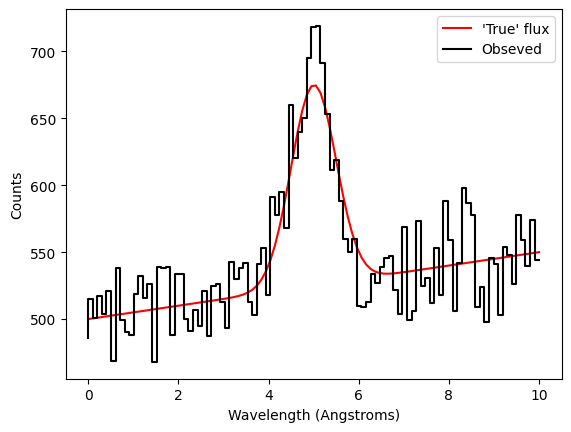

In [2]:
%matplotlib inline
from matplotlib.pyplot import plot, step, xlabel, ylabel, show, legend, subplots
plot(wave, flux, 'r-', label="'True' flux")
step(wave, obs_flux, color='k', label="Obseved")
xlabel('Wavelength (Angstroms)')
ylabel('Counts')
legend(loc="best")
show()

## Bayes' Theorem
Let's say we have some data $\vec{D}$. In the case of our emission line, the data is the number of counts in each wavelength bin. We have a model with some number of parameters $\vec{\theta}$. Bayes' theorem simply states: $$P\left(\vec{\theta}\left|\vec{D}\right.\right) = \frac{P\left(\vec{D}\left|\vec{\theta}\right.\right)P\left(\vec{\theta}\right)}{P\left(\vec{D}\right)}$$

What this says is that the probability that we get a particular set of parameters given a fixed set of data (which is what we want) is proportional to the probability that we get the data given a fixed set of parameters (which we can calculate) times the probability of the parameters (the priors). The denominator is the probability that we got the data we did, which requires integrating over all possible parameters: $$P\left(\vec{D}\right) = \int P\left(\vec{D}\left|\vec{\theta}\right.\right)P\left(\vec{\theta}\right)\ d\vec{\theta}$$ and really just ensures that the probability is normalized to 1.

You might wonder what the difference between the **priors** $P\left(\vec{\theta}\right)$ and $P\left(\vec{\theta}\left|\vec{D}\right.\right)$ (called the **likelihood**) is.
- the **likelihood** is what your data tells you about the parameters
- the **priors** are constraints that are external to the data
  - it could be a previous experiment's result that you are incorporating into your own
  - it could be a purely logical constraint (e.g., the age of the universe must be greater than 0)
  - it could even be a gut feeling

### The Priors
Our five parameters are
- cont_zp
- cont_slope
- amp
- center
- width

The order of these parameters will be fixed. The MCMC module we will be using is called emcee. Let's first define the model: a function that, given the parameters, predicts the observations.

In [3]:
def model(x, cont, slope, amp, center, width):
    model = amp * exp(-0.5 * power(x - center, 2) / width**2) + cont + slope*x
    return model

Now we write some python functions that give us the ingredients of Bayes' formula. First up are the **priors** $P\left(\vec{\theta}\right)$.  We make a function that takes the parameters as a list (keeping the order we've established). Let's say we insist the width of the line must be positive (what does a negative width even mean?) and we know it's an emission line, so amp should be positive. If we don't specify anything, parameters are assumed to have a uniform (equal) probability. Emcee also wants the natural logarithm of the probability, so we call it `lnprior()`.

In [4]:
def lnprior(theta, constraints):
    cont, slope, amp, center, width = theta
    min_width, min_slope = constraints
    if width <= min_width or slope < min_slope:
        return -inf # ln(0)
    return 0

### The likelihood
Next, we need the likelihood $P(\vec{D}|\vec{\theta})$. Given the parameters $\vec{\theta}$, the model $M(x,\vec{\theta})$ is given by the function model(). Under our assumptions, this model will differ from the observed data because of Poisson errors. For large counts, the Poisson distribution is well-approximated by a normal distribution with variance ($\sigma^2$) equal to the counts. So, given a set of parameters $\vec{\theta}$, the probability we measure the flux in channel $i$ to be $f_i$ given by: $$P\left(f_i\left|\vec{\theta}\right.\right) = N\left(M(\vec{\theta}), \sqrt{f_i}\right)$$, where $N$ is the normal distribution. For the entire data-set, we have to multiply the probabilities of all the individual channels. Or, since we need the log of the probability: $$P\left(\vec{D}\left|\vec{\theta}\right.\right) = \Pi_i P\left(f_i\left|\vec{\theta}\right.\right)$$ We'll use scipy's stats module, which has the normal distribution (and its logarithm) built in. Just like the priors, emcee wants the natural logarithm of the probability, so instead of multiplying all the probabilities, we sum all the logarithms of the probabilities.

In [5]:
from scipy.stats import norm

def lnlike(theta, wave, flux):
    m = model(wave, *theta)
    sum_ln_probs = sum(norm.logpdf(flux, loc=m, scale=sqrt(flux)))
    return sum_ln_probs

### The 'Numerator'
Lastly, we construct the numerator of Bayes' formula. We won't compute the denominator, since it is a constant and we are only interested in the shape of $P\left(\vec{\theta}\left|\vec{D}\right.\right)$, since we are only interested in parameter inference. In other words, we only care about the relative probability of different values of the parameters. If we were comparing two models and wanted to know which was more likely the correct one, then we'd need the compute the denominator as well to get a full probability.

In [6]:
def lnprob(theta, wave, flux, constraints):
    lp = lnprior(theta, constraints)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(theta, wave, flux)

### Now create some walkers
So now we create a number of walkers and start them off in random locations around parameter space. In this example, we know the true values so we just perturb around that. When you don't know the true values, you could start in completely random locations or use other tools (like curve_fit) to find an initial starting point.

In [7]:
Nwalker, Ndim = 50, 5
ptrue = array([500., 5.0, 150., 5.0, 0.5])

# add a random vector 0.1 times the true vector to the true vector
p0 = [ptrue + 0.1*random.randn(Ndim)*ptrue for i in range(Nwalker)]

So we now have Nwalker initial points. We can run the emcee sampler, givin it the lnprob function and any extra arguments it needs. The run_mcmc function takes the initial starting points and how many steps you want each to take. It returns the last position, probability, and state of each walker.

In [8]:
import emcee
constraints = (0.1, 0.1)
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(wave, obs_flux, constraints))
pos, prob, state = sampler.run_mcmc(p0, 500)

So let's see what each walker did. We'll graph the value of each parameter as a function of step number. Each walker will have its own line.

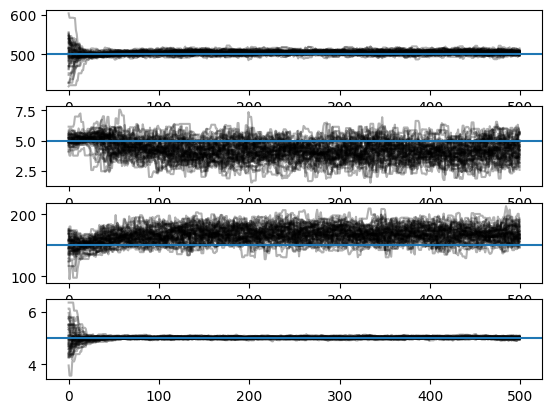

In [9]:
fig,ax = subplots(4,1)
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3) for i in range(4)]
res = [ax[i].axhline(ptrue[i]) for i in range(4)]

As you can see, the walkers can start out rather far from the true value (blue horizontal lines), but after some time, they all converge to a value close to the true value (though not equal, thanks to the noise we added). It's at this point that we say the MCMC chain has converged. Since we're sure this is the case (make sure), we can reset the chains and run for a longer time to get good statistics.

In [10]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 10000)

Once the sampler is done, we can do statistics on the "chains". The sampler object has an attribute flatchain, where all the walkers are combined. This gives us Nwalkers*Nsteps samples from the posterior. We could get the best-fit values and errors by doing statistics on the chains:

In [11]:
print(mean(sampler.flatchain, axis=0))  # best-fit, well really expectation value
print(std(sampler.flatchain, axis=0))   # errors

# deviation from true parameters in units of standard error
print((mean(sampler.flatchain, axis=0)-ptrue)/std(sampler.flatchain, axis=0))
print(cov(sampler.flatchain.T))         # covariance matrix

[5.04097837e+02 4.23296573e+00 1.69396344e+02 5.01375362e+00
 4.47361420e-01]
[ 4.71191275  0.79527619 11.59989261  0.03399527  0.03570884]
[ 0.869676   -0.96448791  1.67211414  0.40457441 -1.47410497]
[[ 2.22021662e+01 -3.10628347e+00 -2.95679140e+00  1.73341859e-02
  -3.13521697e-02]
 [-3.10628347e+00  6.32465477e-01 -1.75817823e-01 -2.25860505e-03
   3.00893164e-04]
 [-2.95679140e+00 -1.75817823e-01  1.34557778e+02  4.96641543e-02
  -2.17942402e-01]
 [ 1.73341859e-02 -2.25860505e-03  4.96641543e-02  1.15568065e-03
  -2.81779911e-04]
 [-3.13521697e-02  3.00893164e-04 -2.17942402e-01 -2.81779911e-04
   1.27512387e-03]]


Lastly, we can visualize the posterior probabilities of the parameters as well as the covariances between them by plotting a corner plot.

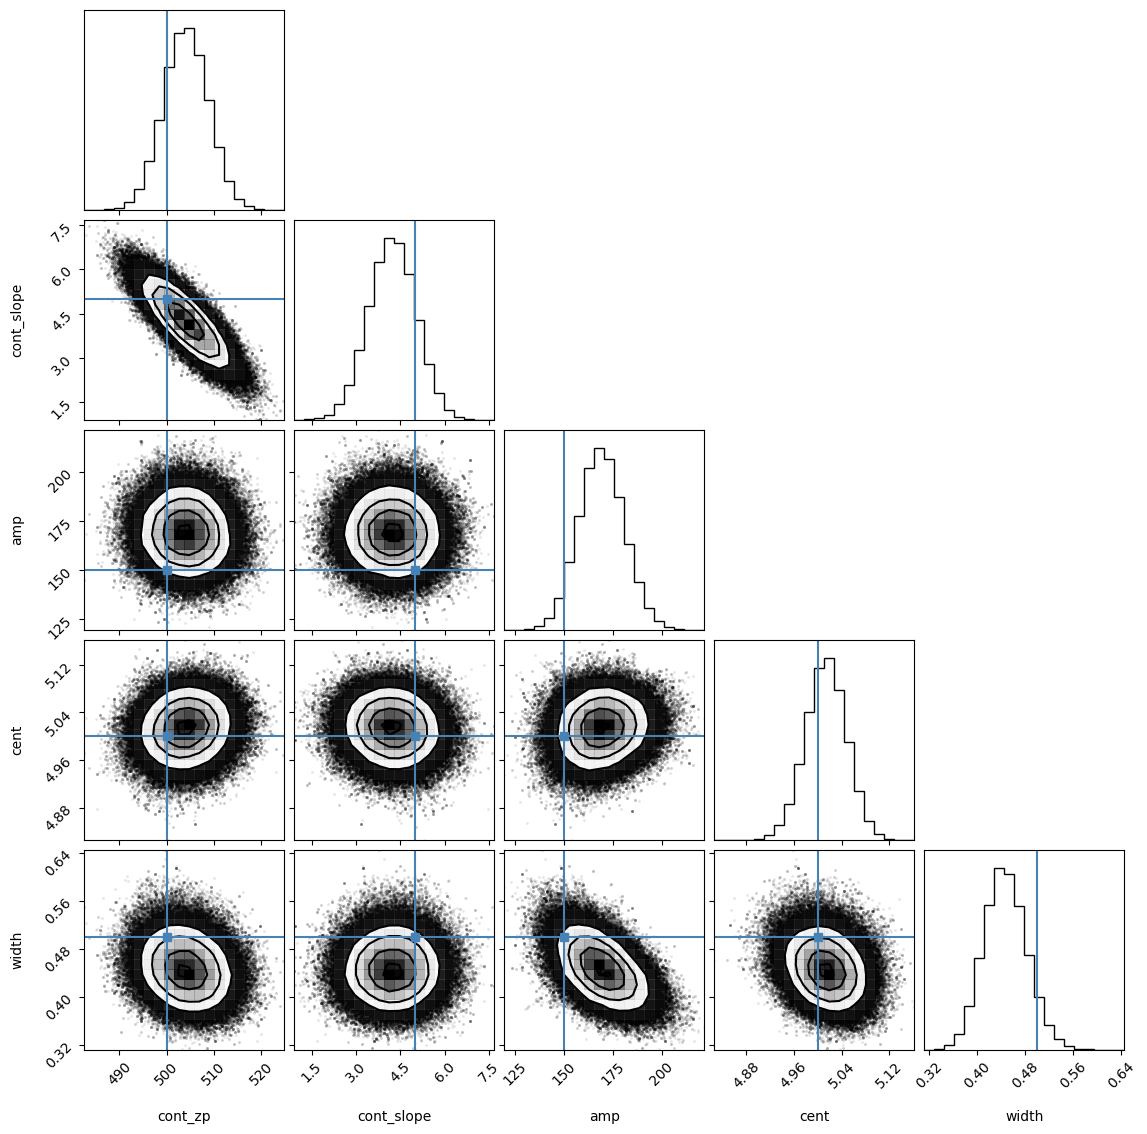

In [12]:
import corner
rmp = corner.corner(sampler.flatchain,
                    labels=['cont_zp', 'cont_slope', 'amp', 'cent', 'width'],
                    truths=[cont_zp, cont_slope, amplitude, center, width])

These corner plots show the covariance between parameters and the histograms show the posterior probability distribution for each parameter. In this case they are all pretty Guassian, so the mean of the distribution is very close to the maximum likelihood (mode) and the standard deviation is a good estimate of the uncertainy. As before, we see that the continuum zero-point and slope are highly covariant, as is the amplitude and width.